## Parameters

In [ ]:
input_shape=[28,28]
batch_size = 128
beta = 1.5
filters=[64,64]
kernels=[3,5]
strides=[2,2]
hidden_dim=300
latent_dim=16
hidden = [7,7]
epochs = 30

## Setups

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
#import tensorflow_datasets as tfds

import warnings
warnings.filterwarnings("ignore")

## Model

In [ ]:
class Sampling(layers.Layer):
    """Sampler. Uses (z_mean, z_log_var) to sample z, the vector encoding a digit."""

    def call(self, inputs):
        z_mean, z_log_var = inputs
        batch = tf.shape(z_mean)[0]
        dim = tf.shape(z_mean)[1]
        epsilon = tf.keras.backend.random_normal(shape=(batch, dim))
        return z_mean + tf.exp(0.5 * z_log_var) * epsilon


In [ ]:
def encoder(input_shape=[28,28], filters=[32,64], kernels=[3,3], strides=[2,2], hidden_dim=16, latent_dim=2):
  """Encoder. Default parameters are taken from Keras example."""
  input = keras.Input(shape=(input_shape[0], input_shape[1], 1))
  x = input
  for i in range(len(filters)):
    x = layers.Conv2D(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

  x = layers.Flatten()(x)
  x = layers.Dense(hidden_dim)(x)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  z_mean = layers.Dense(latent_dim, name="z_mean")(x)  #encoder encodes to mean and var=std^2. We sample random vector from these values
  z_log_var = layers.Dense(latent_dim, name="z_log_var")(x)
  z = Sampling()([z_mean, z_log_var])
  enc = keras.Model(input, [z_mean, z_log_var, z], name="encoder")
  return enc

In [ ]:
def decoder(latent_dim=2, hidden=[7,7], filters=[64, 32], kernels=[3,3], strides=[2,2]):
  """Decoder."""
  input = keras.Input(shape=(latent_dim,))
  x = layers.Dense(hidden[0]*hidden[1]*filters[0])(input)
  x = layers.BatchNormalization()(x)
  x = layers.Activation('relu')(x)

  x = layers.Reshape((hidden[0], hidden[1], filters[0]))(x)

  for i in range(len(filters)):
    x = layers.Conv2DTranspose(filters=filters[i], kernel_size=kernels[i], strides=strides[i], padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation('relu')(x)

  x = layers.Conv2DTranspose(1, 3, padding="same")(x)
  x = layers.BatchNormalization()(x)
  output = layers.Activation('sigmoid')(x)

  dec = keras.Model(input, output, name="decoder")
  return dec

In [ ]:
class bVAE(keras.Model):
  """Creating model"""
  def __init__(self, beta, encoder, decoder, **kwargs):
    super(bVAE, self).__init__(**kwargs)
    self.encoder = encoder
    self.decoder = decoder
    self.beta = beta
    self.total_loss_tracker = keras.metrics.Mean(name="total_loss")
    self.reconstruction_loss_tracker = keras.metrics.Mean(name="reconstruction_loss")
    self.kl_loss_tracker = keras.metrics.Mean(name="kl_loss")

  @property
  def metrics(self):
    return [
            self.total_loss_tracker,
            self.reconstruction_loss_tracker,
            self.kl_loss_tracker,
            ]

  def train_step(self, data):
    with tf.GradientTape() as tape:
      z_mean, z_log_var, z = self.encoder(data)
      reconstruction = self.decoder(z)
      reconstruction_loss = tf.reduce_mean(
          tf.reduce_sum(keras.losses.binary_crossentropy(data, reconstruction), axis=(1, 2))
          )
      kl_loss = -self.beta*0.5 * (1 + z_log_var - tf.square(z_mean) - tf.exp(z_log_var))
      kl_loss = tf.reduce_mean(tf.reduce_sum(kl_loss, axis=1))
      total_loss = reconstruction_loss + kl_loss
      grads = tape.gradient(total_loss, self.trainable_weights)
      self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
      self.total_loss_tracker.update_state(total_loss)
      self.reconstruction_loss_tracker.update_state(reconstruction_loss)
      self.kl_loss_tracker.update_state(kl_loss)
      return {
          "loss": self.total_loss_tracker.result(),
          "reconstruction_loss": self.reconstruction_loss_tracker.result(),
          "kl_loss": self.kl_loss_tracker.result(),
          }

In [ ]:
enc = encoder(input_shape=input_shape, filters=filters, kernels=kernels, strides=strides, hidden_dim=hidden_dim, latent_dim=latent_dim)
dec = decoder(latent_dim=latent_dim, hidden=hidden, filters=filters[-1::-1], kernels=kernels[-1::-1], strides=strides[-1::-1])

vae = bVAE(beta, enc, dec)
vae.compile(optimizer=keras.optimizers.Adam())  
vae.load_weights('latest_checkpoint')

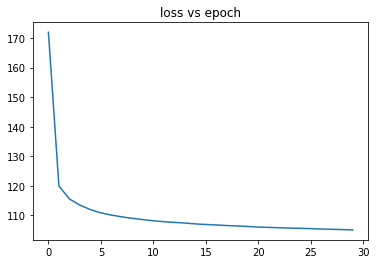

In [ ]:
history = (pd.read_csv('bvae_output.output',skiprows=11,sep=' ')[['loss','Unnamed: 1','reconstruction_loss']].
           rename(columns={'reconstruction_loss':'kl_loss','Unnamed: 1':'reconstruction_loss'}))
history.plot(y='loss',title='loss vs epoch',legend=False);

## Dataset

on splits and determinism  


In [ ]:
(x_train, y_train), (x_test, y_test) = keras.datasets.mnist.load_data()
digits = np.expand_dims(x_train, -1).astype("float32") / 255

11501568/11490434 [==============================] - 0s 0us/step


## Reconstructions

In [ ]:
def reconstructed_image(img, model, text,cmap='binary'): #img is usual batch of gray image (None, .., .., 1)
  encoded = model.encoder.predict(img)
  decoded =  model.decoder.predict(encoded[2])  #0 element on mean, 2 element is sampled x,y in latent space

  plt.rcParams['font.size'] = 15
  fig, panel = plt.subplots(decoded.shape[0], 2, figsize=(10,20))
  for i in range(decoded.shape[0]):
    panel[i,0].imshow(img[i,:,:,0],cmap=cmap)
    panel[i,0].axis('off')
    panel[i,1].imshow(decoded[i,:,:,0],cmap=cmap)
    panel[i,1].axis('off')

  panel[0,0].set_title(f'original')  
  panel[0,1].set_title(f'reconstruction')
  fig.suptitle(text,y=0.91)
  #fig.tight_layout()
  plt.show()

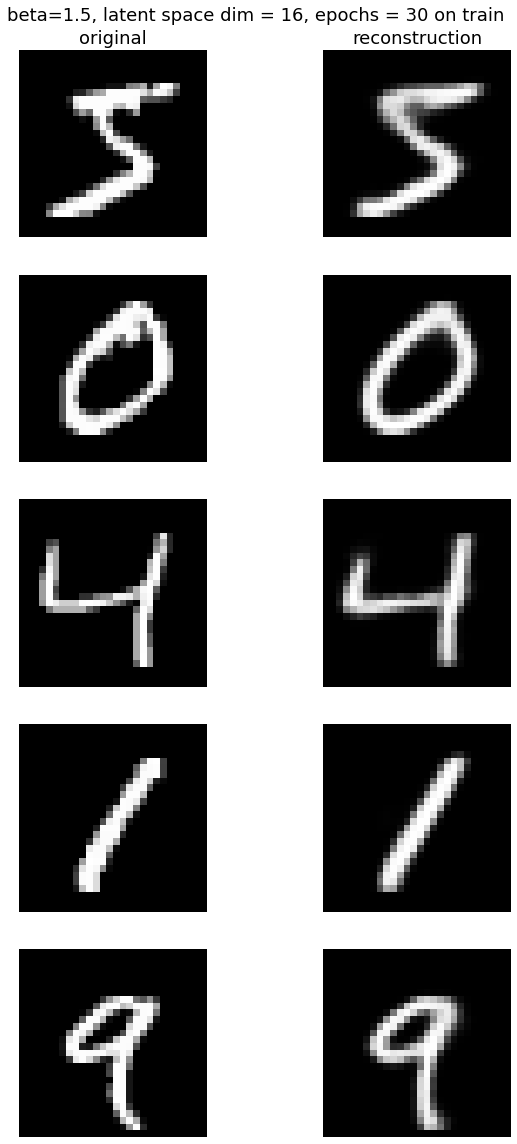

In [ ]:
reconstructed_image(digits[:5], vae, f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs} on train',cmap='binary_r')

In [ ]:
digits_test = np.expand_dims(x_test, -1).astype("float32") / 255

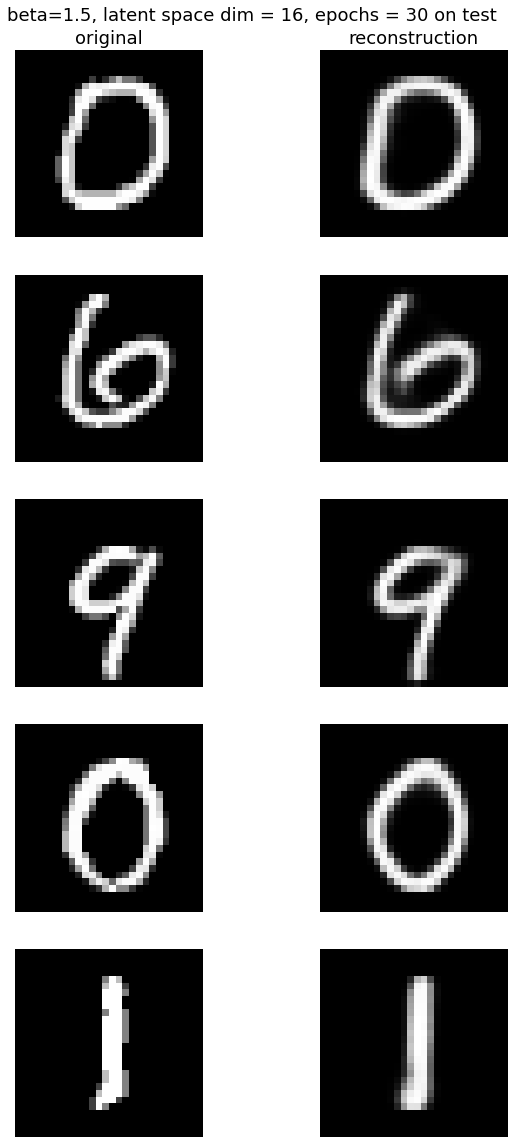

In [ ]:
reconstructed_image(digits_test[10:15], vae, f'beta={beta}, latent space dim = {latent_dim}, epochs = {epochs} on test',cmap='binary_r')

#### Reconstructions for various beta

In [ ]:
def reconstructed_image_all(img, betas, files, text,cmap='binary'):  #img is usual batch of gray image (None, .., .., 1)
  plt.rcParams['font.size'] = 35
  fig, panel = plt.subplots(img.shape[0], len(files)+1, figsize=(30,21), gridspec_kw = {'wspace':0, 'hspace':0})
  for i in range(img.shape[0]):
    panel[i,0].imshow(img[i,:,:,0],cmap=cmap)
    panel[i,0].axis('off')
  panel[0,0].set_title(f'original')
  
  for k,file in enumerate(files):
    enc = encoder(input_shape=input_shape, filters=filters, kernels=kernels, strides=strides, hidden_dim=hidden_dim, latent_dim=latent_dim)
    dec = decoder(latent_dim=latent_dim, hidden=hidden, filters=filters[-1::-1], kernels=kernels[-1::-1], strides=strides[-1::-1])
    v = bVAE(betas[k], enc, dec)
    v.compile(optimizer=keras.optimizers.Adam())
    v.load_weights(file)

    encoded = v.encoder.predict(img)
    decoded = v.decoder.predict(encoded[2])  #0 element on mean, 2 element is sampled x,y in latent space

    for i in range(decoded.shape[0]):
      panel[i,k+1].imshow(decoded[i,:,:,0],cmap=cmap)
      panel[i,k+1].axis('off')

  for j in range(len(files)):
    panel[0,j+1].set_title(f'beta={betas[j]}')
  #fig.suptitle(text,y=0.91)
  #fig.tight_layout()  
  plt.show()
  #plt.savefig('test_cars_all_betas.pdf', dpi=900)  

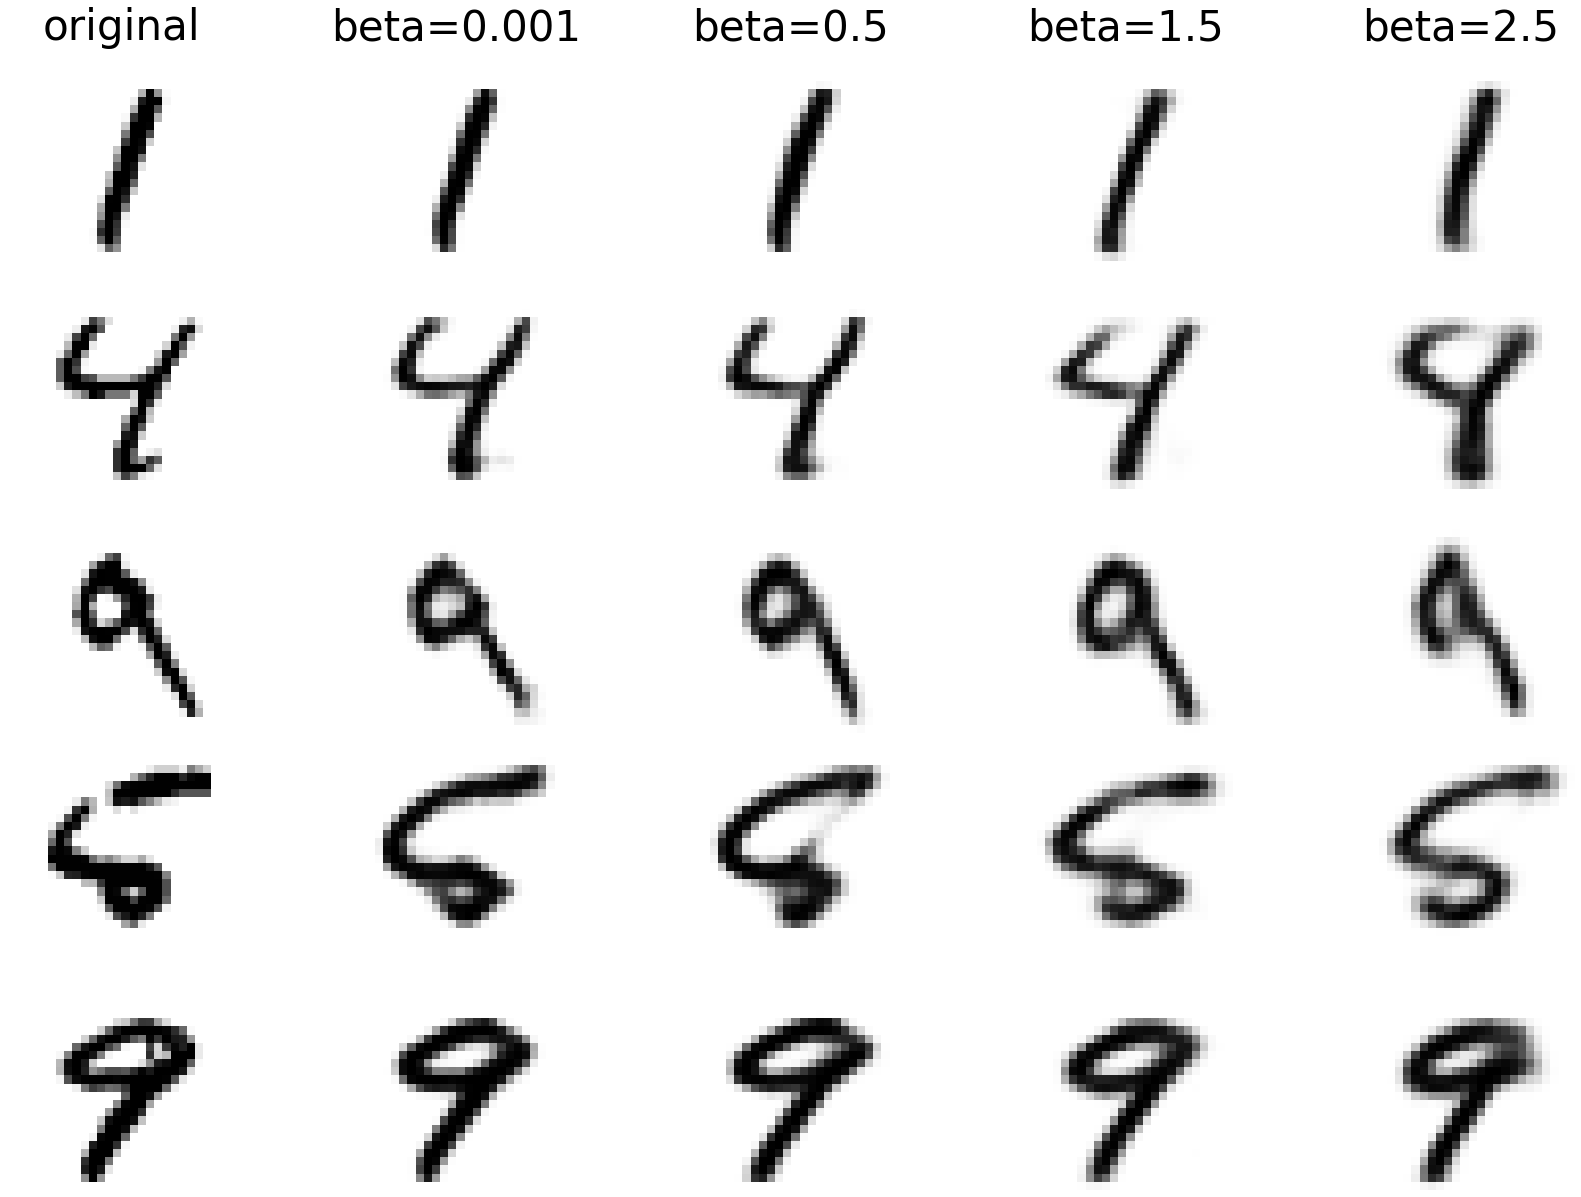

In [ ]:
betas=[0.001,0.5,1.5,2.5]
files = [f'all/{beta}/latest_checkpoint' for beta in betas]
reconstructed_image_all(digits_test[5:10], betas, files, 'dd',cmap='binary')

In [ ]:
def traversals_decoded(img, model,variations=7, component=10): #img is single image (1, .., .., 1)
  encoded = model.encoder.predict(img)

  mean = encoded[0]
  varied = np.linspace(-3,3,variations)
  batch = np.repeat(mean,len(varied),axis=0)
  batch[:,component] = varied

  decoded =  model.decoder.predict(batch)
  
  std_component = np.sqrt(np.exp(encoded[1][0][component]))  #encoded[1] is log_var
  mean_component = mean[0][component]
  
  return decoded, mean_component, std_component

def traversals_plot(img, model, text, variations=7, features=[1,2,3] ,cmap='binary'):
  plt.rcParams['font.size'] = 15
  fig, panel = plt.subplots(len(features), variations+1, figsize=(10,20),gridspec_kw = {'wspace':0, 'hspace':0})
  #plt.subplots_adjust(wspace=0, hspace=0)
  for i,f in enumerate(features):
    images, mean, std = traversals_decoded(img, model, variations=variations, component=f)
    panel[i,0].imshow(img[0,:,:,0],cmap=cmap)
    panel[i,0].text(-10, 20, f'{f}')
    panel[i,0].axis('off')
    for j in range(images.shape[0]):
      panel[i,j+1].imshow(images[j,:,:,0],cmap=cmap)
      panel[i,j+1].axis('off')
    panel[i,images.shape[0]].text(30, 15, f'{mean:.2f}')
    panel[i,images.shape[0]].text(30, 25, f'{std:.2f}')

  panel[0,0].set_title(f'original')
  for i,v in enumerate([-3,-2,-1,0,1,2,3]): panel[0,i+1].set_title(f'{v}')

  #fig.suptitle(text,y=0.89)
  
  #fig.tight_layout()
  plt.show()

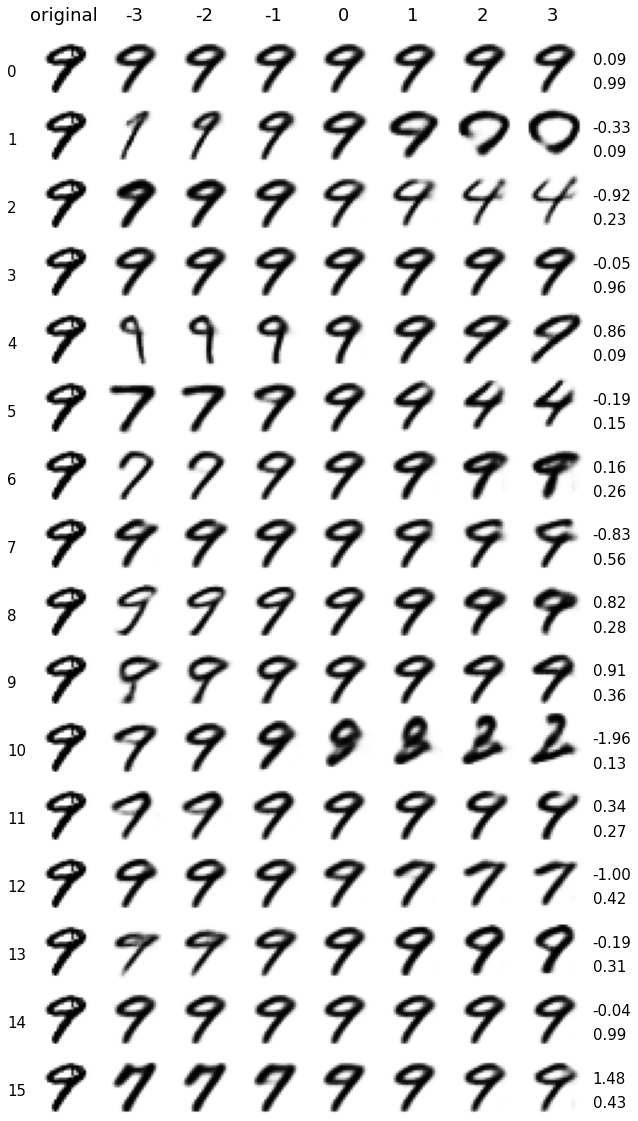

In [ ]:
traversals_plot(digits_test[9:10], vae, f'beta={beta}, latent={latent_dim} ', features=np.arange(latent_dim))

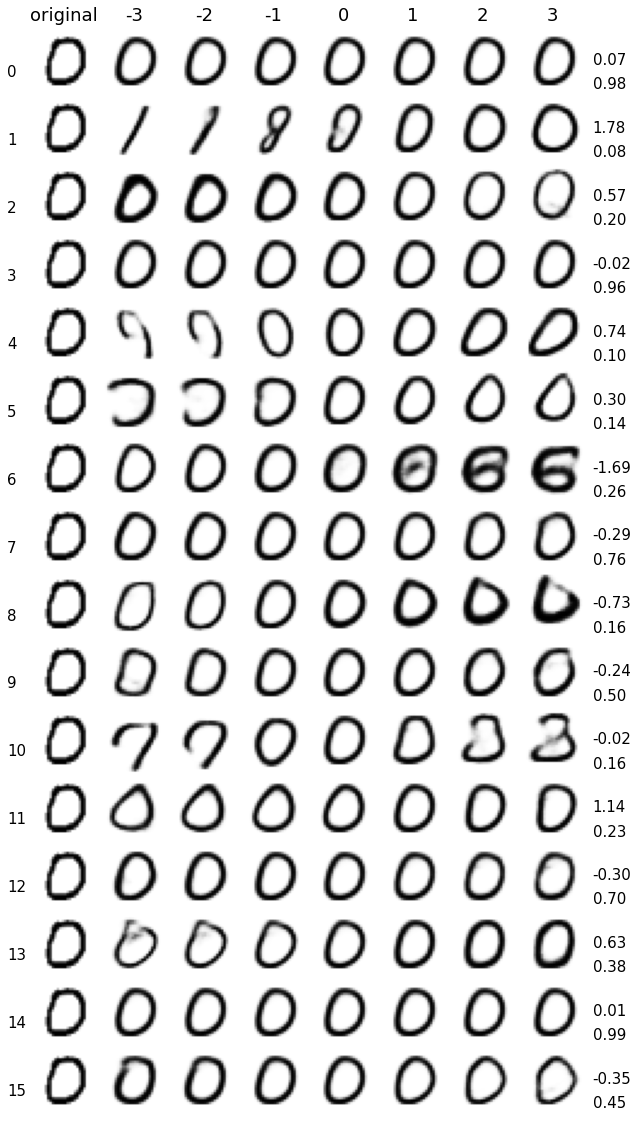

In [ ]:
traversals_plot(digits_test[10:11], vae, f'beta={beta}, latent={latent_dim} ', features=np.arange(latent_dim))